<a href="https://colab.research.google.com/github/Cranjis-McB/Py_ngransac/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 2.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30

In [1]:
# Import useful modules.
import os, shutil
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

import util
from network import CNNet

In [2]:
help(util)

Help on module util:

NAME
    util

FUNCTIONS
    AUC(losses, thresholds, binsize)
        Compute the AUC up to a set of error thresholds.
        
        Return mutliple AUC corresponding to multiple threshold provided.
        
        Keyword arguments:
        losses -- list of losses which the AUC should be calculated for
        thresholds -- list of threshold values up to which the AUC should be calculated
        binsize -- bin size to be used fo the cumulative histogram when calculating the AUC, the finer the more accurate
    
    create_parser(description)
        Create a default command line parser with the most common options.
        
        Keyword arguments:
        description -- description of the main functionality of a script/program
    
    create_session_string(prefix, fmat, orb, rootsift, ratio, session)
        Create an identifier string from the most common parameter options.
        
        Keyword arguments:
        prefix -- custom string appended at

# NG-RANSAC

What is [RANSAC](http://www.cs.ait.ac.th/~mdailey/cvreadings/Fischler-RANSAC.pdf)?

Random Sample Consensus (RANSAC) is an iterative model for estimating a model from a dataset that contains outliers. It chooses a group of hypothesis **randomly** where each hypothesis contains the minimal data points to estimate the model, also called minimal set. The model is estimated using each hypothesis, and all the data points are asked to vote for the hypothesis (i.e. count the number of datapoints that lies with epsilon error of the estimated model using the hypothesis). The hypothesis gets the most vote decides the inliers, and these inliers estimates the final model. 

In our case this model is **Fundamental Matrix**.

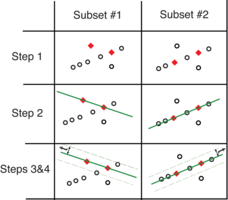
               
               Figure: RANSAC

In **NG-RANSAC**,  Each datapoint is assigned a weight, these weights are calculated using the (pretrained) neural net. Instead of choosing the hypothesis randomly (like in RANSAC), **The minimal set in each hypothesis is guided by these weights**, hence the name Neural Guided RANSAC.

In [18]:
'''
    Given the Correspondences (points in image-1 and corresponding
    matching points in image-2), and Fundamental Matrix, it computes
    the fundamental error for these points.
'''

def epipolar_error(hom_pts1, hom_pts2, F):
  
  """Compute the symmetric epipolar error."""
  res  = 1 / np.linalg.norm(F.T.dot(hom_pts2)[0:2], axis=0)
  res += 1 / np.linalg.norm(F.dot(hom_pts1)[0:2], axis=0)
  res *= abs(np.sum(hom_pts2 * np.matmul(F, hom_pts1), axis=0))
  
  return res


'''
* @brief Find fundamental matrix given 2D-2D correspondences.
* 
* Method uses RANSAC with guided sampling (NG-RANSAC) and the 7-point algorithm of OpenCV.
* 
* @param correspondences 3-dim float tensor, dim 1: xy coordinates of left and right image (in pixels), dim 2: correspondences, dim 3: dummy dimension
* @param probabilities 3-dim float tensor, dim 1: sampling weight, dim 2: correspondences, dim 3: dummy dimension
* @param randSeed random seed
* @param hypCount number of hypotheses/iterations for RANSAC
* @param inlierThresh inlier threshold (in pixels)
* @param refine if true, model will be refined by running the 8-point algorithm on all inliers

'''

def find_fundamental_mat(correspondences,
                         probabilities,
                         randSeed = 42,
                         hypCount = 1000,
                         inlierThresh = 1.0,
                         refine = True):
    
    computeErrT = inlierThresh * inlierThresh  # we will calculate the squared error
    cCount = probabilities.shape[1]  # number of correspondences
    cMin = 7  # size of the minimal set
    inlierCounts = -1

    # Read Correspondences and weights.
    pts1 = []
    pts2 = []
    wPts = []

    correspondences = correspondences.tolist()
    probabilities = probabilities.tolist()
    
    for i in range(cCount):
        pts1.append([correspondences[0][i][0], correspondences[1][i][0]])
        pts2.append([correspondences[2][i][0], correspondences[3][i][0]])
        wPts.append(probabilities[0][i][0])
    
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    # 2D coordinates to 3D homogeneous coordinates
    hom_pts1 = np.concatenate((pts1, np.ones((len(pts1), 1))), axis=1)
    hom_pts2 = np.concatenate((pts2, np.ones((len(pts2), 1))), axis=1)
    
    #  normalize wpts to 1.
    wPts = np.asarray(wPts).astype('float64')
    wPts = wPts / np.sum(wPts)

    # NG-RANSAC. (RANSAC Guided by Pre-trained Neural Weights)
    for h in range(hypCount):
        
        minSet1 = []
        minSet2 = []
        for j in range(cMin):
            
            # Sampling from multinomial distribution.
            multinomial_arr = np.random.multinomial(1, wPts) # Neural Guidance
            idx = np.nonzero(multinomial_arr)[0][0]
            minSet1.append(pts1[idx])
            minSet2.append(pts2[idx])
        
        minSet1 = np.array(minSet1)
        minSet2 = np.array(minSet2)
        
        # Calculate Fundamental Matrix from Minimal Sets.
        try:
            
            F, mask = cv2.findFundamentalMat(minSet1, minSet2, cv2.FM_7POINT)
            
            # potentially more than one model, select according to inlier count
            countF = F.shape[0] // 3
            
        except:
            
            # Error, No valid Solution
            countF = 0
            
        if countF == 0:
            
            F = np.eye(3, dtype = float)
            countF = 1
            
        # select best solution according to inlier count
        for e in range(countF):
            
            curF = F[3*e : 3*e + 3]
            err = epipolar_error(hom_pts1.T, hom_pts2.T, curF)
            curMask = np.where(err < computeErrT, 1, 0)
            curInlierCount  = sum(curMask)
            
            # Choose best solution.
            if curInlierCount > inlierCounts:

                inlierCounts = curInlierCount  # Best inlier Count
                bestF = curF   # Best Fundamental Matrix
                bestM = curMask  # Best Mask

    # Refine the Fundamental matrix based on best score.
    if refine and (inlierCounts > 7):
        
        # recalculate F matrix on all inliers
        inds = np.where(bestM == 1)
        in_pts1 = pts1[inds]
        in_pts2 = pts2[inds]
        bestF, M = cv2.findFundamentalMat(in_pts1, in_pts2, cv2.FM_8POINT)
        
        if len(bestF) == 0:
            bestF = np.eye(3, dtype = float) # Refinement Failed
            
    if  inlierCounts < 7:
        bestF = np.eye(3, dtype = float) # Refinement Failed
        
    return bestF, bestM, inlierCounts

# Fundamental Matrix Estimation.

## Step-1: Calculating Root-Sift Matches between two images.

In [4]:
nfeatures = 2000

detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures, contrastThreshold=1e-5)
detector

<xfeatures2d_SIFT 0x7f0e77331090>

Text(0.5, 1.0, 'Image-2')

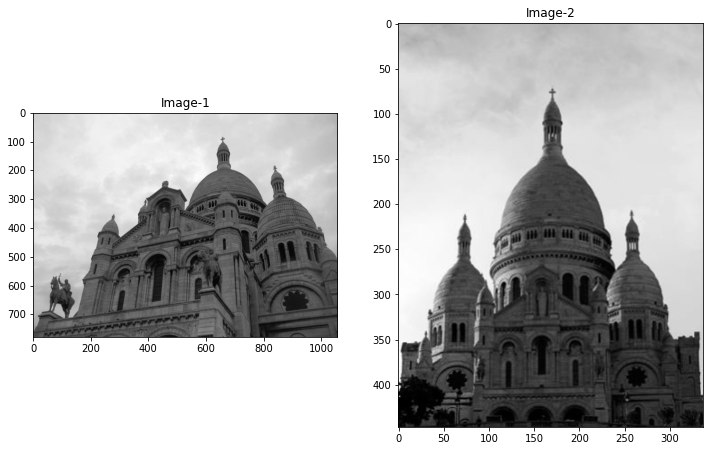

In [6]:
# read images
img1 = cv2.imread('/content/00318781_8039756060.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('/content/02786360_4030483701.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

f, ax = plt.subplots(1, 2, figsize = (12,12))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title("Image-1")
ax[1].imshow(img2, cmap='gray')
ax[1].set_title("Image-2")

In [7]:
# detect features
kp1, desc1 = detector.detectAndCompute(img1, None)
kp2, desc2 = detector.detectAndCompute(img2, None)

print("Using RootSIFT normalization.")
desc1 = util.rootSift(desc1)
desc2 = util.rootSift(desc2)

Using RootSIFT normalization.


In [8]:
# feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)

good_matches = []
pts1 = []
pts2 = []

#side information for the network (matching ratios in this case)
ratios = []


for (m,n) in matches:
	if m.distance < 0.8*n.distance: # apply Lowe's ratio filter
		good_matches.append(m)
		pts2.append(kp2[m.trainIdx].pt)
		pts1.append(kp1[m.queryIdx].pt)
		ratios.append(m.distance / n.distance)

print("Number of valid matches:", len(good_matches))

Number of valid matches: 89


In [9]:
pts1 = np.array([pts1])
pts2 = np.array([pts2])

ratios = np.array([ratios])
ratios = np.expand_dims(ratios, 2)

# Step-2: F-matrix Calculation Using RANSAC

In [10]:
# === CASE FUNDAMENTAL MATRIX =========================================
ransac_model, ransac_inliers = cv2.findFundamentalMat(pts1, pts2, ransacReprojThreshold=1.0, confidence=0.999)

print("\n=== Model found by RANSAC: ==========\n")
print(ransac_model)

print("\nRANSAC Inliers:", ransac_inliers.sum())


=== Model found by RANSAC: ==========

[[-7.26421008e-07 -8.02502239e-06  8.78660895e-03]
 [ 8.15234328e-06 -1.87083151e-06 -7.90359008e-03]
 [-3.66261344e-03  3.42588496e-03  1.00000000e+00]]

RANSAC Inliers: 23


# Step-3: F-matrix Calculation Using NG-RANSAC

In [11]:
resblocks = 12
device = torch.device('cpu')

In [12]:
# Load the Model
model_file = '/content/weights_e2e_F_rs_r0.80_.net'
model = CNNet(resblocks)
model.load_state_dict(torch.load(model_file, map_location=device))
#model = model.cuda()
model.eval()
print("Successfully loaded model.")

Successfully loaded model.


In [13]:
# normalize x and y coordinates before passing them to the network
# normalized by the image size
util.normalize_pts(pts1, img1.shape)
util.normalize_pts(pts2, img2.shape)

In [14]:
# create data tensor of feature coordinates and matching ratios
correspondences = np.concatenate((pts1, pts2, ratios), axis=2)
correspondences = np.transpose(correspondences)
correspondences = torch.from_numpy(correspondences).float()

# predict neural guidance, i.e. RANSAC sampling probabilities
log_probs = model(correspondences.unsqueeze(0))[0] #zero-indexing creates and removes a dummy batch dimension
probs = torch.exp(log_probs).cpu()

In [15]:
# undo normalization of x and y image coordinates
util.denormalize_pts(correspondences[0:2], img1.shape)
util.denormalize_pts(correspondences[2:4], img2.shape)

In [21]:
# === CASE FUNDAMENTAL MATRIX Using NG-RANSAC=========================================
ngransac_model, ngransac_inliers, incount = find_fundamental_mat(correspondences,
                                                                  probs,
                                                                  randSeed = 42,
                                                                  hypCount = 1000,
                                                                  inlierThresh = 1.0,
                                                                  refine = True)

print("\n=== Model found by NG-RANSAC: ==========\n")
print(ngransac_model)

print("\nNGRANSAC Inliers:", ngransac_inliers.sum())


=== Model found by NG-RANSAC: ==========

[[-4.42259413e-07 -8.28974970e-06  7.40779715e-03]
 [ 7.97526393e-06 -1.54010611e-06 -7.27868736e-03]
 [-3.36155857e-03  3.12188386e-03  1.00000000e+00]]

NGRANSAC Inliers: 26


# Visualization

Text(0.5, 1.0, 'RANSAC vs NG-RANSAC')

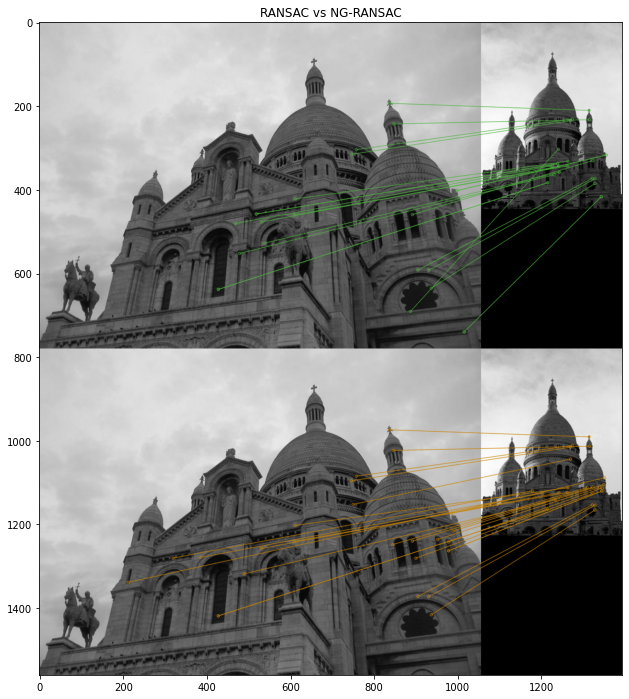

In [24]:
# create a visualization of the matching, comparing results of RANSAC and NG-RANSAC
ransac_inliers = ransac_inliers.ravel().tolist()
ngransac_inliers = ngransac_inliers.ravel().tolist()

match_img_ransac = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2, matchColor=(75,180,60), matchesMask = ransac_inliers)
match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2, matchColor=(200,130,0), matchesMask = ngransac_inliers)
match_img = np.concatenate((match_img_ransac, match_img_ngransac), axis = 0)

plt.figure(figsize = (12, 12))
plt.imshow(match_img)
plt.title("RANSAC vs NG-RANSAC")

=====================================================================================